### Nonlinear Regression realization

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from tqdm import tqdm
import itertools

# plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
class ZNormalizer(object):
    def fit(self,x):
        self.mean = x.mean(axis=0)
        self.std = x.std(axis=0)
    
    def transform(self,x):
        return (x - self.mean) / self.std  

def plot_decision_line(x, y, model):
    x = x.data.cpu().numpy()
    y = y.data.cpu().numpy()
    
    i = np.argsort(x)
    x = x[i]
    y = y[i]
    
    plt.scatter(x, y, s=5)
    y_hat = model(torch.tensor(x)).data.cpu().numpy()
    plt.scatter(x, y_hat, s=5)
    plt.fill_between(x, y, y_hat, alpha=0.1)
    plt.show()
    
def shuffle_and_split(x, y, ratio):
    size = round(x.shape[0] * ratio)
    
    i = np.random.permutation(x.shape[0])
    x = x[i]
    y = y[i]

    x_train = x[:size]
    y_train = y[:size]

    x_test = x[size:]
    y_test = y[size:]
    
    return (x_train, y_train), (x_test, y_test)    
    
def load_data():
    rng = np.random.RandomState(40)
    
    x = np.linspace(0, 10, 1000)
    
    size = 5
    os = range(size)
    ps = rng.uniform(-1., 1., size=size)
    
    y = 0.
    for p, o in zip(ps, os):
        y = y + p * np.sin(x * 2**o)
        
    return x, y

def mae(input, target):
    return torch.mean(torch.abs(input - target))

def mse(input, target):
    return torch.mean((input - target)**2)    

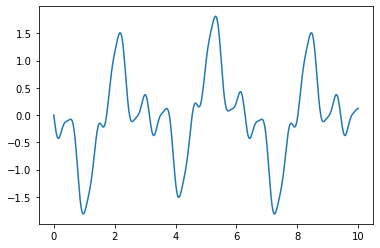

In [3]:
# load data, separate and normalize

data = load_data()
plt.plot(data[0], data[1])

(x_train, y_train), (x_test, y_test) = shuffle_and_split(*data, 0.8)

norm = ZNormalizer()
norm.fit(x_train)

x_train = norm.transform(x_train)
x_test = norm.transform(x_test)

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        size = 32
        depth = 5 
        
        self.layer1 = nn.Linear(1, size)
        self.layer2 = nn.ModuleList([nn.Linear(size, size) for _ in range(depth)])
        self.layer3 = nn.Linear(size, 1)
    
    
    def forward(self, x):
        
        x = self.layer1(x.unsqueeze(1))
        x = torch.tanh(x)
        
        for l in self.layer2:
            x = l(x)
            x = torch.tanh(x)
        
        x = self.layer3(x)
        
        x = torch.squeeze(x,1)
        return x 

epoch 0, train loss 0.63, test loss 0.66


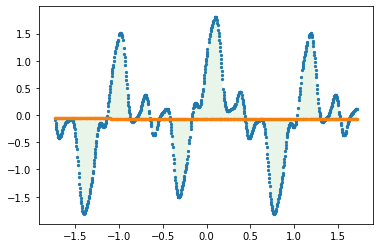

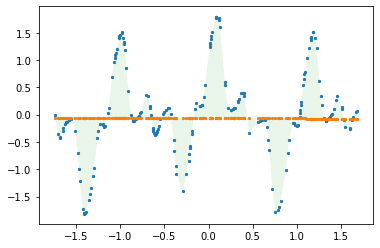

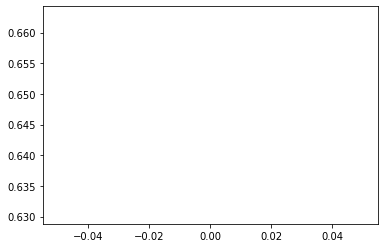

epoch 1000, train loss 0.59, test loss 0.61


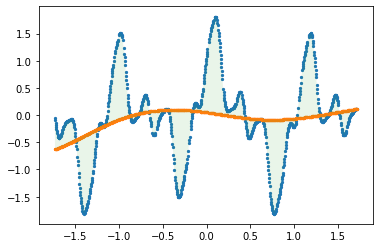

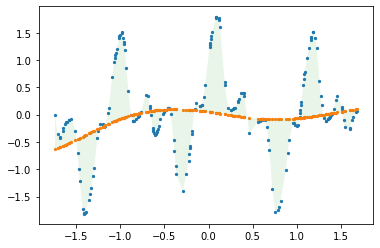

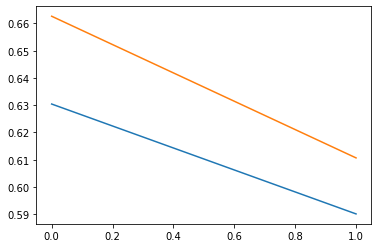

epoch 2000, train loss 0.28, test loss 0.30


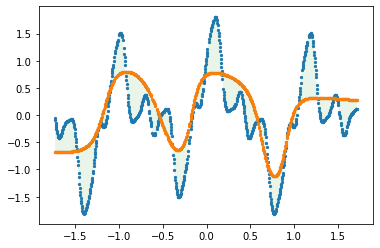

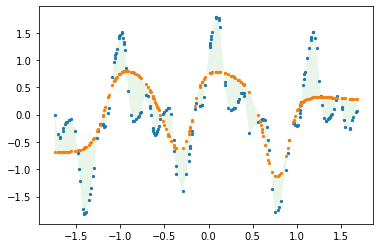

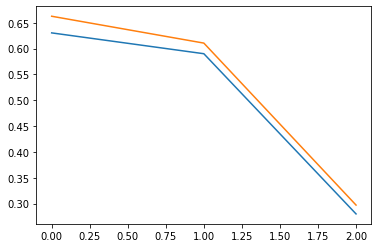

epoch 3000, train loss 0.16, test loss 0.19


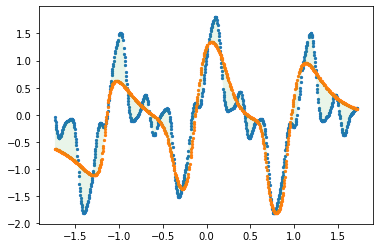

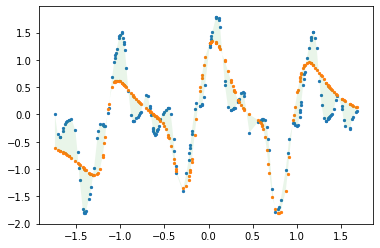

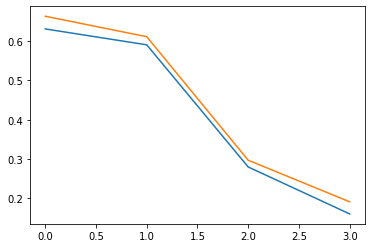

epoch 4000, train loss 0.14, test loss 0.17


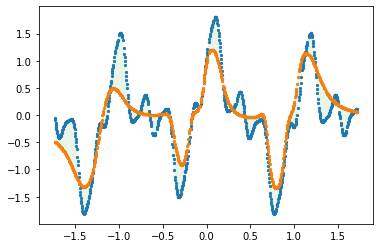

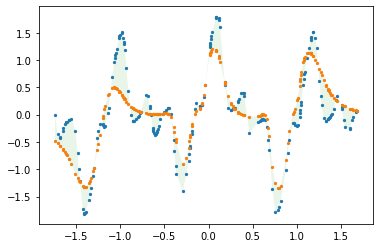

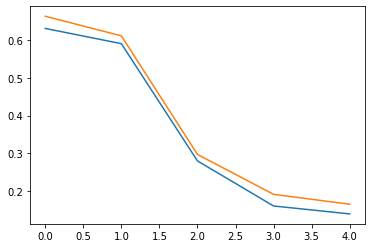

epoch 5000, train loss 0.10, test loss 0.10


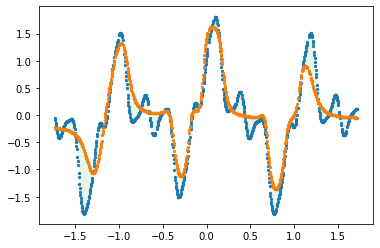

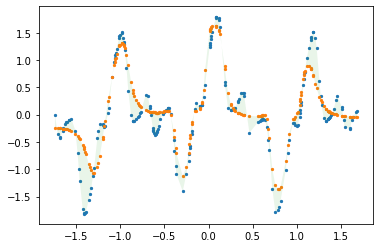

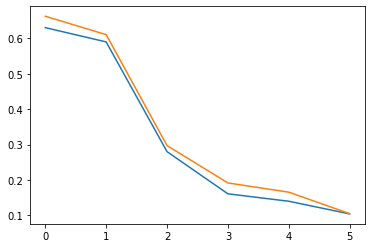

epoch 6000, train loss 0.07, test loss 0.07


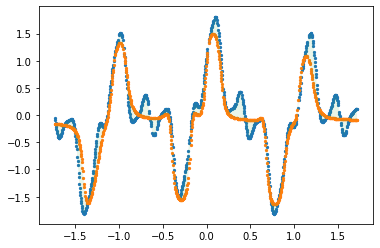

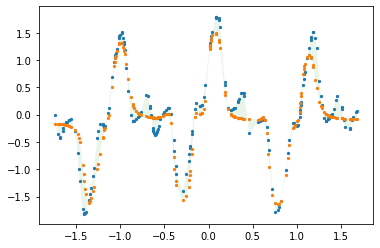

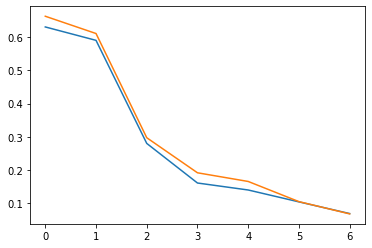

epoch 7000, train loss 0.04, test loss 0.04


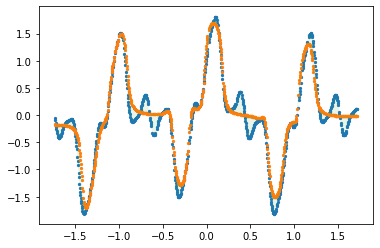

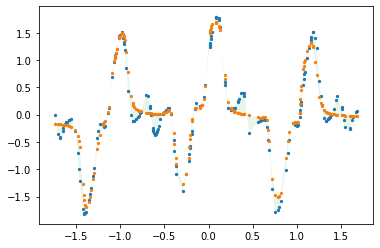

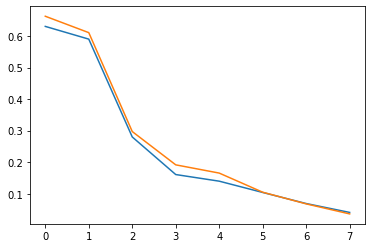

epoch 8000, train loss 0.03, test loss 0.03


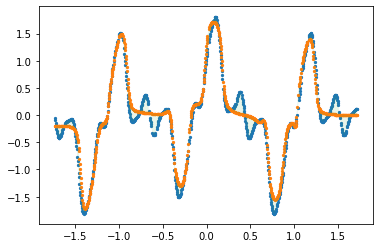

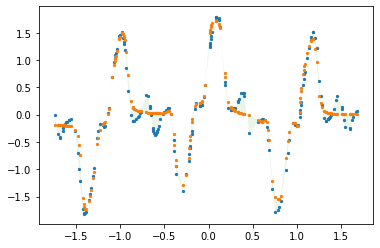

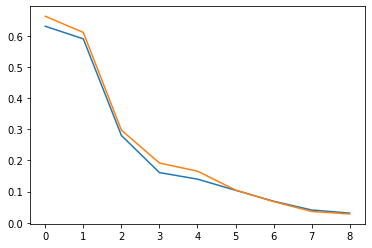

epoch 9000, train loss 0.03, test loss 0.02


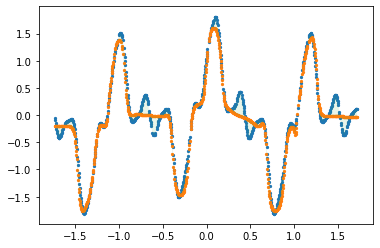

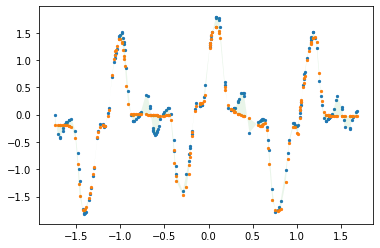

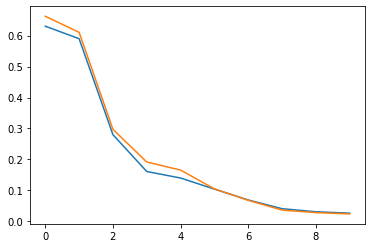

epoch 10000, train loss 0.03, test loss 0.02


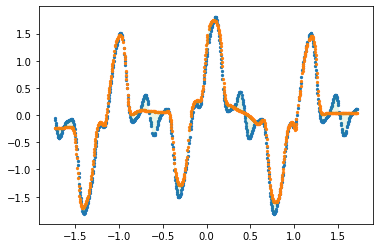

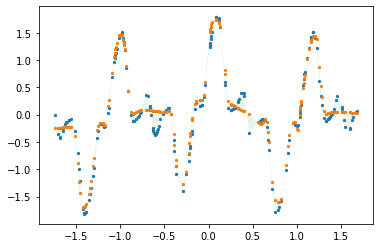

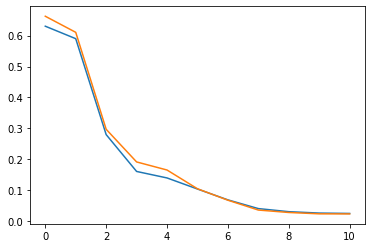

epoch 11000, train loss 0.02, test loss 0.02


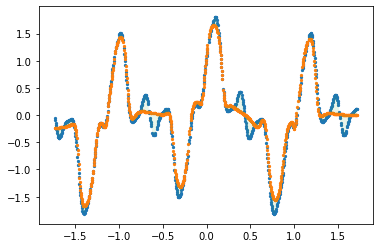

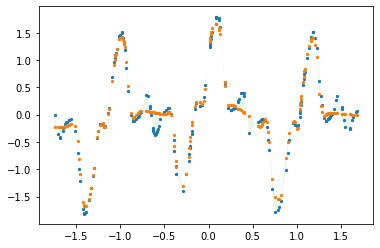

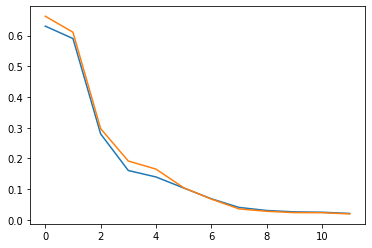

epoch 12000, train loss 0.02, test loss 0.02


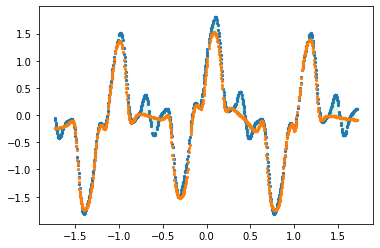

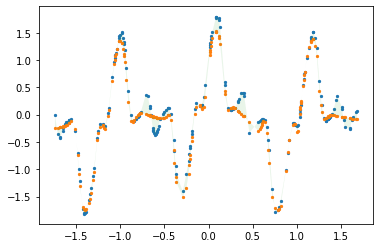

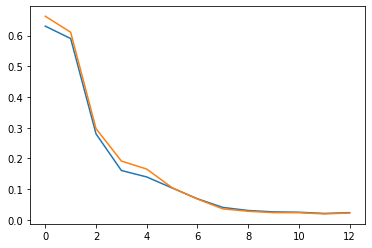

epoch 13000, train loss 0.02, test loss 0.02


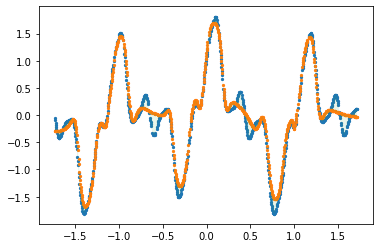

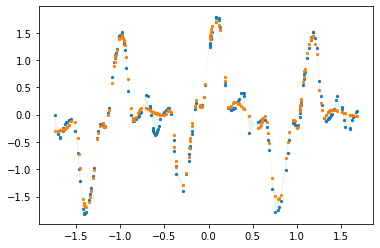

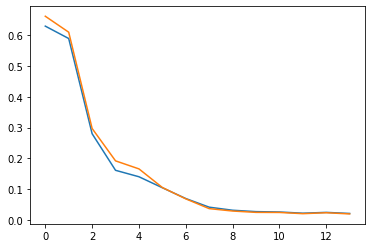

epoch 14000, train loss 0.03, test loss 0.02


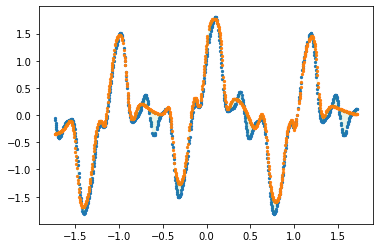

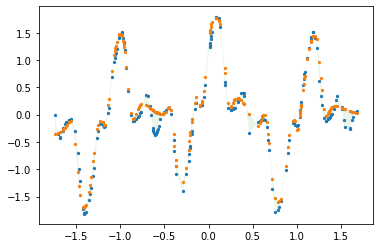

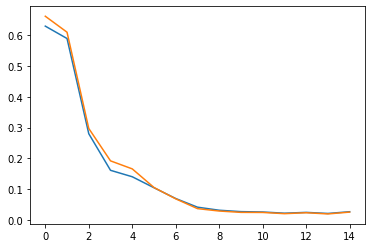

epoch 15000, train loss 0.02, test loss 0.02


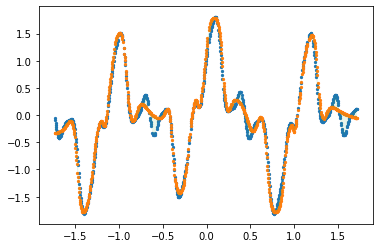

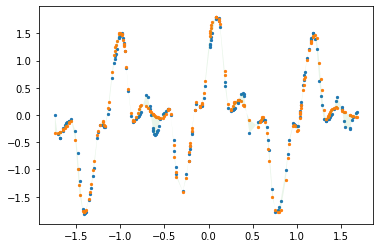

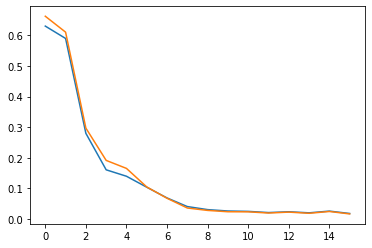

epoch 16000, train loss 0.01, test loss 0.01


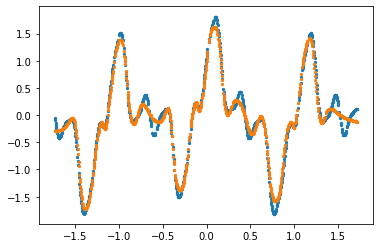

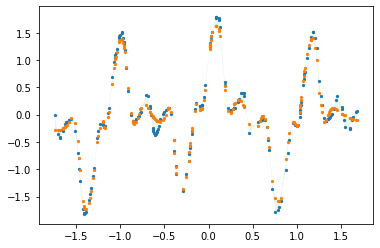

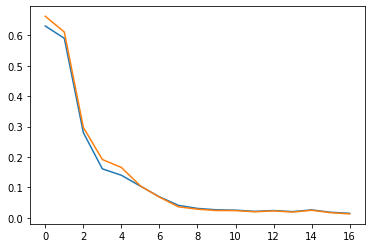

epoch 17000, train loss 0.02, test loss 0.01


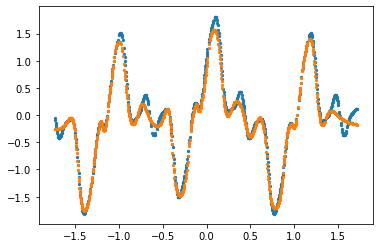

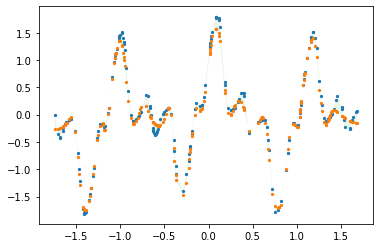

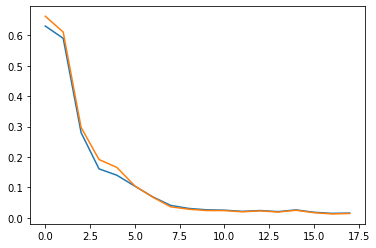

epoch 18000, train loss 0.02, test loss 0.02


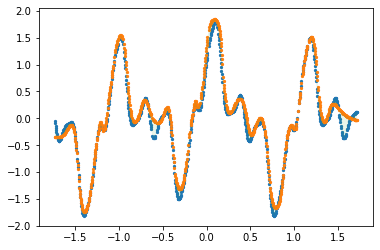

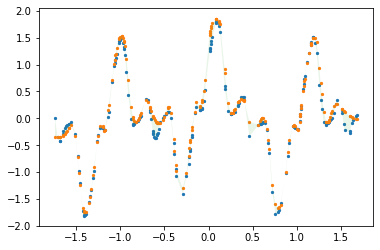

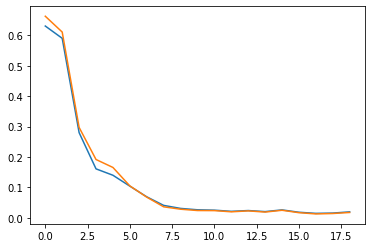

epoch 19000, train loss 0.01, test loss 0.01


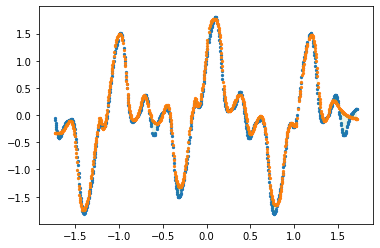

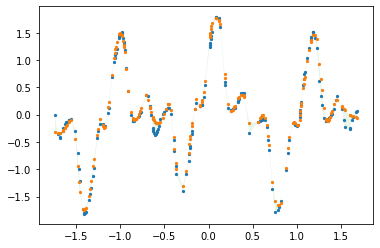

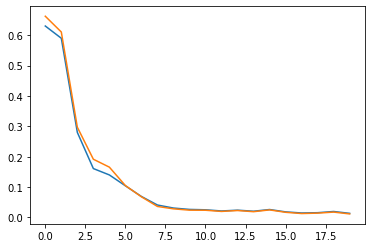

In [5]:
# model initialization
model = Model()

log_int = 1000
lr = 1e-1

stats = {
    'train_loss': [],
    'test_loss': [],
}
for epoch in range(20000):
    # train set forward pass
    y_hat_train = model(x_train)
    #print(y_hat_train.shape, y_train.shape, x_train.shape)
    
    train_loss = mse(input = y_hat_train, target = y_train)
    
    if epoch % log_int == 0:
        opt = torch.optim.SGD(model.parameters(), lr)
        y_hat_test = model(x_test)
        
        #print(y_hat_test.shape, y_test.shape)
        
        test_loss = mse(input = y_hat_test, target = y_test)
        # test set forward pass
        
        print('epoch {}, train loss {:.2f}, test loss {:.2f}'.format(epoch, train_loss, test_loss))
        stats['train_loss'].append(train_loss.data.numpy())
        stats['test_loss'].append(test_loss.data.numpy())
        
        #print(x_train.shape, y_train.shape)
        
        plot_decision_line(x_train, y_train, model)
        plot_decision_line(x_test, y_test, model)
        
        plt.plot(stats['train_loss'])
        plt.plot(stats['test_loss'])
        plt.show()

    # optimization step
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    